In [2]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [4]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066

8.066

In [79]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [90]:
σ = 5*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [91]:
#=function tabulate(sd::fitsd, full_real::Bool=true, npoints::Int=5)
    sd.ωs, sd.jws
end=#

In [92]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [58]:
ϵ0 = 0.0 # Based on typical NN exciton Hamiltonians
ϵb = 134.0
ϵ2b = -10.7

-10.7

In [59]:
N = 10

10

In [60]:
H0 = Matrix{ComplexF64}(zeros(N, N))

10×10 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [61]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-2
        H0[i, i+2] = ϵ2b
    end
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
    if i>=3
        H0[i, i-2] = ϵ2b
    end
end

In [62]:
H0 = H0 * invcm2au

10×10 Matrix{ComplexF64}:
         0.0+0.0im  0.000610548+0.0im  …          0.0+0.0im
 0.000610548+0.0im          0.0+0.0im             0.0+0.0im
 -4.87527e-5+0.0im  0.000610548+0.0im             0.0+0.0im
         0.0+0.0im  -4.87527e-5+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im  …          0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im     -4.87527e-5+0.0im
         0.0+0.0im          0.0+0.0im     0.000610548+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im

In [97]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * invcm2au
g0p = ωpg0p ./ ωp
jws = (g0p.^(2))
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [0.0008650519031141869, 0.00055177694698437, 0.0003231915162226992, 1.7023804664001344e-6, 0.0002734018267790112, 0.00013771615591192445, 1.2674501281845861e-5, 0.00021681013046385349, 0.0006948698503452422], 0.007259600589, 1.0, false)

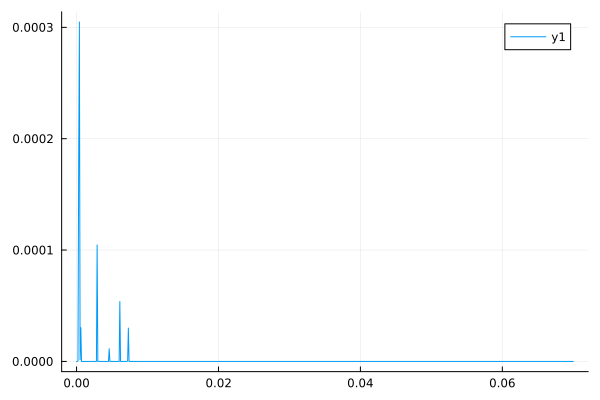

In [98]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω))

In [66]:
nsteps = 1000
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[5, 5] = 1

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [67]:
dt = 0.05 / au2fs

0.25

In [68]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

(0.0:0.25:250.0, [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 5.516925833297793e-21 + 0.0im -1.3818056983892334e-19 + 2.1927138866437735e-22im … 5.51692580116444e-21 + 4.488748605521741e-32im -1.0705474297010856e-27 - 8.42085477460484e-25im; … ; 1.5085128987854038e-8 + 1.7863411880986726e-9im -1.5961905069362926e-7 + 2.1452988120164024e-7im … 2.227678351192129e-8 + 4.658205901477691e-11im -1.116348959564969e-9 - 1.5418606172811268e-9im; 1.516493464173609e-8 + 1.7962292647936102e-9im -1.603148171685622e-7 + 2.156099351894913e-7im … 2.2400476242934133e-8 + 4.6913467811167456e-11im -1.1231748933308458e-9 - 1.5510274930578896e-9im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -1.381734125723695e-19 - 2.192600311791815e-22im 3.460970572725262e-18 + 0.0im … -1.3818056903408836e-19 - 2.1927138851151207e-22im -6.6552277936329e-27 + 2.1091471842288252e-23im; … ; -5.352752085758071e-8 - 7.748913281718547e-8im 3.354351975126084e-6 - 4.180185553684833e-8im … -1.7581057571633622e-7 -

QCPI doesn't compile. I need to figure out where the pipeline is going wrong

In [17]:
## QCPI Run

ω, c = discretize(Jw, 9)
hb = Solvents.HarmonicBath(β, ω, c, [1.0, -1.0], 10)

tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate, verbose=false) 

LoadError: DimensionMismatch: array could not be broadcast to match destination

HEOM only runs with Drude-Lorentz spectral densities...

In [18]:
## Running with HEOM

λs = repeat([35.0], N) * invcm2au
γs = 1 ./ (repeat([50.0], N) ./ au2fs)
JwD = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwD, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

@time th, ρh = HEOM.propagate(; Hamiltonian=H0, ρ0=ρ0, Jw=JwD, β, ntimes=nsteps, dt, sys_ops, num_modes=2, Lmax=3, scaled=true, threshold=1e-10, extraargs=Utilities.DiffEqArgs(; reltol=1e-6, abstol=1e-6))

172.866153 seconds (204.49 M allocations: 103.351 GiB, 12.03% gc time, 7.05% compilation time)


([0.0, 0.04134137457575099, 0.08268274915150198, 0.12402412372725297, 0.16536549830300395, 0.20670687287875494, 0.24804824745450593, 0.2893896220302569, 0.3307309966060079, 0.3720723711817589  …  40.96930220456923, 41.01064357914498, 41.05198495372073, 41.093326328296484, 41.134667702872235, 41.176009077447986, 41.21735045202374, 41.25869182659949, 41.30003320117524, 41.34137457575099], [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 4.1254712380377936e-24 + 0.0im -1.0332992641140066e-22 + 5.940523320997629e-26im … 4.125470501992541e-24 + 2.5090868401503146e-35im 1.086531262103404e-30 - 2.281390589777094e-28im; … ; 4.445525099424744e-12 + 0.0im -1.0367303837358203e-10 + 2.7002049567841067e-11im … 4.443639865476778e-12 + 1.5084311064973053e-16im -2.1779624369062965e-14 - 1.0590624308875383e-13im; 4.464029226294137e-12 + 0.0im -1.0409030999790148e-10 + 2.713751638336541e-11im … 4.4621329118159375e-12 + 1.5190353180259193e-16im -2.191080226831292e-14 - 1.0644201071691874e-13im;;; 0.0 

In [70]:
MSD = []
for i in 1:nsteps
    s = 0.0
    for j in 1:N
        s += real(ρ[i, j, j])*((j-5)^2)
    end
    push!(MSD, s)
end

In [71]:
display("text/plain", MSD)

1000-element Vector{Any}:
 0.0
 4.7784555508125266e-8
 1.9113822203250106e-7
 4.3006099957312737e-7
 7.645528727408873e-7
 1.1946138107583336e-6
 1.7202437674612553e-6
 2.3414426813010205e-6
 3.058210475347706e-6
 3.870547057293995e-6
 4.778452319459864e-6
 5.781926138798041e-6
 6.880968376900244e-6
 ⋮
 0.04644404705265704
 0.04653797373859796
 0.046631995113793026
 0.04672611117722004
 0.0468203219278563
 0.046914627364678566
 0.04700902748666321
 0.04710352229278617
 0.04719811178202301
 0.04729279595334888
 0.04738757480573861
 0.04748244833816672

In [73]:
μ = β * (MSD[nsteps] - MSD[1])/(t[nsteps] - t[1])

0.20011590272284147

In [74]:
t .*= au2fs

LoadError: CanonicalIndexError: setindex! not defined for StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

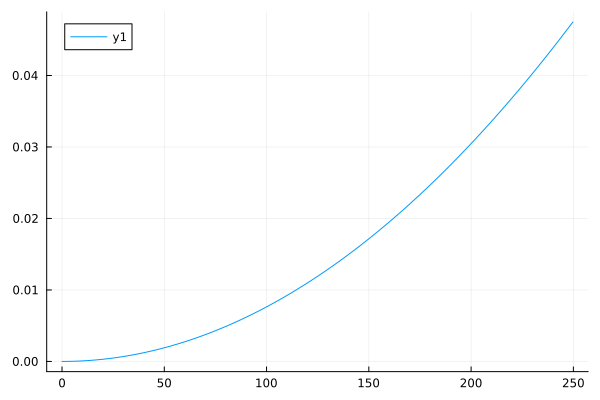

In [75]:
plot(t[1:nsteps], MSD, fmt= :png)

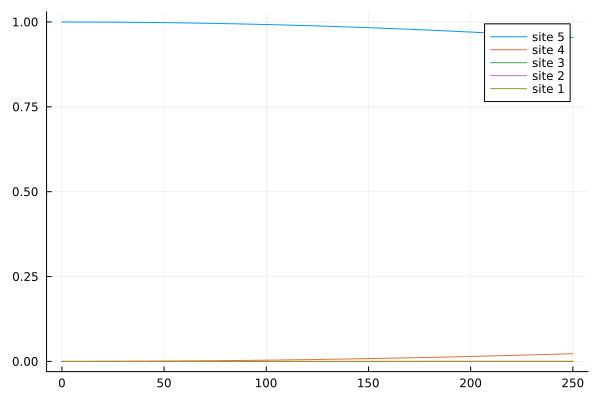

In [77]:
plot(t, real.(ρ[:, 5, 5]), label="site 5")
plot!(t, real.(ρ[:, 4, 4]), label="site 4")
plot!(t, real.(ρ[:, 3, 3]), label="site 3")
plot!(t, real.(ρ[:, 2, 2]), label="site 2")
plot!(t, real.(ρ[:, 1, 1]), label="site 1")